# Data Creation Process

> This an example of how to get a feature set developed for a batch model

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
from pathlib import Path
from machine_learning_utilities.dataset_creation.snowflake import pull_features_from_snowflake

import yaml

In [ ]:
#| hide

def write_yaml_file(file_path: str, file_name: str, dictionary: dict):
    with open(Path(file_path, file_name), 'w') as f:
        yaml.dump(dictionary, f)

# Data Preperation Steps

## Snowflake Feature Store

> Using MSU process

### **Step 1**: Creating a base query set for your specific project. 

The idea behind this is that this query allows you to customize the people you want inside of each year of your training data set. So an example of this could the that you want to only build LTBP to have guest that buy passes at all rather than the decision that was made to have guest that scanned in the year. 

There is no right answer for the type of guest you want to put into your model. This could be argued that the guest that were on a ticket that buy a past the next year can be found with this ECID group, but another arguement could be that guest that have pass for the year are a better trend. This experimentation can be solved by using this type of logic.

> There are limitations to this base query, but this base query is what we are using to be able to leverage the feature store that is simply just a bunch of UDF calls to snowflake to allow for simple and stable calls to generate feature sets

In [ ]:
#| skip
# This model has been going for a long time we only use 3 years of data but this is a legacy project being moved over
season_year=['2017/18', '2018/19', '2019/20', '2020/21', '2021/22']
# Changing these to the season end years so that we don't get confused what year the data is for
seasons=['17_18', '18_19', '19_20', '20_21', '21_22']

In [ ]:
#| skip
for sy, s in zip(season_year, seasons):
    with open(Path('./LTBP/files/sql_files/', f'training_ecids_{s}.sql'), 'w') as f:
        f.write(f"""select
distinct fs.ECID as ecid,
dd.SeasonYear as SeasonYear
from BIDE_EDWDB_ARA_PROD.dbo.FactScan fs
left join BIDE_EDWDB_ARA_PROD.dbo.DimDateSeason dd
on dd.DateSeasonKey = fs.DateSeasonKey
where
dd.SeasonYear in ('{sy}')
and fs.IsEmployee = 0
and dd.Season = 'Winter'
LIMIT 10000
""")

This is just showing a quick example of what happens **pull_features_from_snowflake** the idea is that each one of these grains will be replace and then each season year will then be put together and unioned together to create a full feature set

In [ ]:
#| skip
from machine_learning_utilities.dataset_creation.snowflake import create_base_query

In [ ]:
#| skip
query = """select
    <MODEL_GRAIN>
    <FEATURES>
    <ADDITIONAL_COLUMNS>
    from
        (base_query) base
    """.replace(" ", "")

season_year = '17_18'

print(create_base_query(file_path=f'./LTBP/files/sql_files/training_ecids_{season_year}.sql', query=query))

select
<MODEL_GRAIN>
<FEATURES>
<ADDITIONAL_COLUMNS>
from
(select
distinct fs.ECID as ecid,
dd.SeasonYear as SeasonYear
from BIDE_EDWDB_ARA_PROD.dbo.FactScan fs
left join BIDE_EDWDB_ARA_PROD.dbo.DimDateSeason dd
on dd.DateSeasonKey = fs.DateSeasonKey
where
dd.SeasonYear in ('2017/18')
and fs.IsEmployee = 0
and dd.Season = 'Winter'
LIMIT 10000
)base



Now that we have a base for each year of a training data what we want to make sure we create a query that will pull all eligible guest into a feature set for inference purposes.

> **NOTE**: You will see a hard coded season year you can replace that with the following command below to always be on the lastest and greatest season year, but there are times in the year where this isn't correct due to system updates that is why you are seeing a hard coded value in this query below.


(select SalesSeason 
    from (select SalesSeason, row_number() over(order by SalesSeason desc) as rank
           from (select distinct SalesSeason 
                   from BIDE_EDWDB_ARA_PROD.DBO.SalesSeason where SalesSeason <> 'Reconciliation Placeholder')
          ) where rank = 1
)


> Also note that this inference query set hasn't been looked at for more than a year and there are most likely better ways to get our guests than this, but we have been using this and will continue to do this until a track of work is opened to resolve this known possible issue


The inference set can be found at ./LTBP/files/sql_files/inference_base.sql

### **Step 2:** Creating Feature Choices and UDF Inputs

Features are going to be udf calls that have been created in the feature store gitlab repo. There are always more and more features available as well as if there are features you want to add please continue to add to the already reach feature store. There are projects that don't quite work for the feature store for one reason or another and that example will be coming in a future project. 

This feature store project is for the projects that have already been in use for more than 2-3 years now. In future project and processes this might completely go away in fav or a ADLS feature store that has ELT process for each of our models but that is still a little bit down the road

Please see [MSU Data Set Creation Example](https://vailresorts.gitlab.io/data-science/machine_learning_utilities/dataset_creation/examples_snowflake/) for more explanation of udf_dict.

#### Explanation of Feature Yaml/Dictionary

You will see some key variables inside of each one of these keys:

1. feature_type

    - STATIC: meaning it's a static udf call from the feature store
    - TEMP: meaning it's a temporal feature call that is going to need udf inputs
    
        - Note: this will probably need advancement as we go into snowpark so this documentation might need updating for more advance or better written udfs

2. input_type

    - Needs to have a corresponding key inside of udf_inputs to allow the function to find what it needs to be inserting into the udf call.

3. input_definition

    - FEATURE: meaning it will be part of the training feature set unless there is a feature selection process that is happening in modeling, but in this version it does not happen.
    - LABEL: meaning this is the dependent variable that is going to be predicted through out the project

4. udf_name

    - Feature store udf name

5. var_type

    - cat: it tells the function that we want to treat this as a categorical feature
    - cont: it tell the function that we want to treat this as a continuous feature

6. transformation

    - Sklearn transformation types expected
        - Note: that this library does not expect more args that MSU shows an example of because this is a template to get quicker results, but if there is a desire to change the standard process you can change ``return_dict_type`` from modeling utils, which is just simplifying process a little which has been nice, but can be voted to be removed if we see fit

7. experiment_list

    - This is a list of names of experiments being ran that a user wants to have a feature part of the modeling process if the name of the experiment is not in the list the feature will be skipped, which allows a user to run the same model for example with a differing feature set to possibly test something like what collinear feature is better to have than another.


> Note: If you want to have dtypes for the snowflake stage query in the modeling process you will need to add dtype to all of these features and then write the logic to pull the dtypes in order similar to how columns is created dynamically already inside of `create_stage_and_query_stage_sf` where features is just the feature_dict below and make sure they are going to be in order

```python 
columns = [col.upper() for col in features.keys()]
```

In [ ]:
#| skip
feature_dict = {
    'GenderCode':
        {
        'feature_type': 'STATIC',
        'input_type': None,
        'input_definition': 'FEATURE',
        'udf_name': 'GenderCode',
        'var_type': {
            'BASELINE': 'cat' ,
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'DESTINATIONGEOAFINITYLABEL':
        {
        'feature_type': 'STATIC',
        'input_type': None,
        'input_definition': 'FEATURE',
        'udf_name': 'DESTINATIONGEOAFINITYLABEL',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
        # Issue with temporal element eventual switch back
        # glv issue spotted and snowpark fixes it
    'MarketingZone':
        {
        'feature_type': 'STATIC',
        'input_type': None,
        'input_definition': 'FEATURE',
        'udf_name': 'MarketingZone',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'Age':
        {
        'feature_type': 'TEMP',
        'input_type': '3_YEAR_DATE_RANGE',
        'input_definition': 'FEATURE',
        'udf_name': 'Age_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cont',
            'NOHYPEROPT': 'cont'
        },
        'transformation': {
            'BASELINE': 'StandardScaler',
            'NOHYPEROPT': 'StandardScaler'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'EverCorePass':
        {
        'feature_type': 'TEMP',
        'input_type': '3_YEAR_DATE_RANGE',
        'input_definition': 'FEATURE',
        'udf_name': 'EverCorePass_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'EverPass':
        {
        'feature_type': 'TEMP',
        'input_type': '3_YEAR_DATE_RANGE',
        'input_definition': 'FEATURE',
        'udf_name': 'EverPass_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'OnlySingleResortKey':
        {
        'feature_type': 'TEMP',
        'input_type': '3_YEAR_DATE_RANGE',
        'input_definition': 'FEATURE',
        'udf_name': 'OnlySingleResortKey_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'PartnerResortScannerFlag':
        {
        'feature_type': 'TEMP',
        'input_type': '3_YEAR_DATE_RANGE',
        'input_definition': 'FEATURE',
        'udf_name': 'PartnerResortScannerFlag_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'TotalSeasonsScanned':
        {
        'feature_type': 'TEMP',
        'input_type': '3_YEAR_DATE_RANGE',
        'input_definition': 'FEATURE',
        'udf_name': 'TotalSeasonsScanned_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'ResortsVisited':
        {
        'feature_type': 'TEMP',
        'input_type': '3_YEAR_DATE_RANGE',
        'input_definition': 'FEATURE',
        'udf_name': 'ResortsVisited_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cont',
            'NOHYPEROPT': 'cont'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'SubSeasonsPerYear':
        {
        'feature_type': 'TEMP',
        'input_type': '3_YEAR_DATE_RANGE',
        'input_definition': 'FEATURE',
        'udf_name': 'SubSeasonsPerYear_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cont',
            'NOHYPEROPT': 'cont'
        },
        'transformation': {
            'BASELINE': 'StandardScaler',
            'NOHYPEROPT': 'StandardScaler'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'MostCommonTicketComp':
        {
        'feature_type': 'TEMP',
        'input_type': '3_YEAR_DATE_RANGE',
        'input_definition': 'FEATURE',
        'udf_name': 'MostCommonTicketComp_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'AvgVisitPerSeason':
        {
        'feature_type': 'TEMP',
        'input_type': '3_YEAR_DATE_RANGE',
        'input_definition': 'FEATURE',
        'udf_name': 'AvgVisitPerSeason_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cont',
            'NOHYPEROPT': 'cont'
        },
        'transformation': {
            'BASELINE': 'StandardScaler',
            'NOHYPEROPT': 'StandardScaler'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'MostSubSeasonVisited':
        {
        'feature_type': 'TEMP',
        'input_type': '3_YEAR_DATE_RANGE',
        'input_definition': 'FEATURE',
        'udf_name': 'MostSubSeasonVisited_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'TotalVisits':
        {
        'feature_type': 'TEMP',
        'input_type': '3_YEAR_DATE_RANGE',
        'input_definition': 'FEATURE',
        'udf_name': 'TotalVisits_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cont',
            'NOHYPEROPT': 'cont'
        },
        'transformation': {
            'BASELINE': 'StandardScaler',
            'NOHYPEROPT': 'StandardScaler'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'VisitMostInPeak':
        {
        'feature_type': 'TEMP',
        'input_type': '3_YEAR_DATE_RANGE',
        'input_definition': 'FEATURE',
        'udf_name': 'VisitMostInPeak_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'MostVisitedRegion':
        {
        'feature_type': 'TEMP',
        'input_type': '3_YEAR_DATE_RANGE',
        'input_definition': 'FEATURE',
        'udf_name': 'MostVisitedRegion_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'MostVisitedResort':
        {
        'feature_type': 'TEMP',
        'input_type': '3_YEAR_DATE_RANGE',
        'input_definition': 'FEATURE',
        'udf_name': 'MostVisitedResort_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'IsEpicMixActivated':
        {
        'feature_type': 'TEMP',
        'input_type': 'SEASONYEAR',
        'input_definition': 'FEATURE',
        'udf_name': 'IsEpicMixActivated_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'MarketingZone':
        {
        'feature_type': 'TEMP',
        'input_type': 'SEASONYEAR',
        'input_definition': 'FEATURE',
        'udf_name': 'MarketingZone_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'SkierabilityLabel':
        {
        'feature_type': 'TEMP',
        'input_type': 'SEASONYEAR',
        'input_definition': 'FEATURE',
        'udf_name': 'SkierabilityLabel_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'GuestBehavior':
        {
        'feature_type': 'TEMP',
        'input_type': 'SEASONYEAR',
        'input_definition': 'FEATURE',
        'udf_name': 'GuestBehavior_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'EverCorePass':
        {
        'feature_type': 'TEMP',
        'input_type': 'ORIGIN_YEAR_DATE_RANGE',
        'input_definition': 'FEATURE',
        'udf_name': 'EverCorePass_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'EverPass':
        {
        'feature_type': 'TEMP',
        'input_type': 'ORIGIN_YEAR_DATE_RANGE',
        'input_definition': 'FEATURE',
        'udf_name': 'EverPass_ECID_Temporal',
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation': {
            'BASELINE': 'OrdinalEncoder',
            'NOHYPEROPT': 'OrdinalEncoder'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
    'BoughtPass': 
        {
        'feature_type': 'TEMP',
        'input_type': 'SEASONYEAR',
        'input_definition': 'LABEL',
        'udf_name': 'BoughtPass_ECID_Temporal', 
        'var_type': {
            'BASELINE': 'cat',
            'NOHYPEROPT': 'cat'
        },
        'transformation' : {
            'BASELINE': None,
            'NOHYPEROPT': 'None'
        },
        'experiment_list': ['BASELINE', 'NOHYPEROPT']
        },
}

In [ ]:
#| skip
udf_inputs = {
    'TRAINING': {
        # TODO: PR to remove this duplication
        'UDF_GRAIN' : ['base.ECID'], # input key to all udfs
        'FEATURE':{
            'BASELINE' : {
                'SEASON_END':{
                    0 : '20181005',
                    1 : '20191005',
                    2 : '20201005',
                },
                '3_YEAR_DATE_RANGE':{
                    0 : ['20171001', '20191005'],
                    1 : ['20181001', '20201005'],
                    2 : ['20191001', '20211005'],
                },
            'SEASONYEAR':{
                    0 :  "\'2017/18\'",
                    1 :  "\'2018/19\'",
                    2 :  "\'2019/20\'",
                },
                'ORIGIN_YEAR_DATE_RANGE':{
                    0 : ['20151005', '20191005'],
                    1 : ['20151005', '20201005'],
                    2 : ['20151005', '20211005'],
                },
            },
        'NOHYPEROPT' : {
                'SEASON_END':{
                    0 : '20181005',
                    1 : '20191005',
                    2 : '20201005',
                },
                '3_YEAR_DATE_RANGE':{
                    0 : ['20171001', '20191005'],
                    1 : ['20181001', '20201005'],
                    2 : ['20191001', '20211005'],
                },
            'SEASONYEAR':{
                    0 :  "\'2017/18\'",
                    1 :  "\'2018/19\'",
                    2 :  "\'2019/20\'",
                },
                'ORIGIN_YEAR_DATE_RANGE':{
                    0 : ['20151005', '20191005'],
                    1 : ['20151005', '20201005'],
                    2 : ['20151005', '20211005'],
                },
            },
        },
        'LABEL' : {
            'BASELINE' : {
                 'SEASONYEAR': {
                    0 :  "\'2019/20\'",
                    1 :  "\'2020/21\'",
                    2 :  "\'2021/22\'",
                    }
            },
            'NOHYPEROPT' : {
                 'SEASONYEAR': {
                    0 :  "\'2019/20\'",
                    1 :  "\'2020/21\'",
                    2 :  "\'2021/22\'",
                    }
            },
        },
        'BASE_QUERY': {
            'BASELINE' : {
                0 : 'training_ecids_18_19.sql',
                1 : 'training_ecids_19_20.sql',
                2 : 'training_ecids_20_21.sql',
                },
            'NOHYPEROPT' : {
                0 : 'training_ecids_18_19.sql',
                1 : 'training_ecids_19_20.sql',
                2 : 'training_ecids_20_21.sql',
                },
        },
        'ADDITIONAL_COLUMNS': {
            'SEASONYEAR': {
                0: "'2018/19'",
                1: "'2019/20'",
                2: "'2020/21'"
            },
        }
    },
    'INFERENCE': {
     'UDF_GRAIN' : ['base.ECID'], # input key to all udfs
     'FEATURE':{
         'BASELINE' : { 
             'SEASON_END': {    
                     0 : '20221005',
                },
            '3_YEAR_DATE_RANGE': {
                     0 : ['20190101', '20221005'],
                },
            'SEASONYEAR': {
                    0 :  "\'2021/22\'",
                },
            'ORIGIN_YEAR_DATE_RANGE': { 
                    0 : ['20051001', '20221005'],
                },
            },
        'NOHYPEROPT' : { 
             'SEASON_END': {    
                     0 : '20221005',
                },
            '3_YEAR_DATE_RANGE': {
                     0 : ['20190101', '20221005'],
                },
            'SEASONYEAR': {
                    0 :  "\'2021/22\'",
                },
            'ORIGIN_YEAR_DATE_RANGE': { 
                    0 : ['20051001', '20221005'],
                },
            },
         },
    'LABEL' : {
        'BASELINE' : {
            'SEASONYEAR' : {
                0 :  "\'2021/22\'",
            }
        },
        'NOHYPEROPT' : {
            'SEASONYEAR' : {
                0 :  "\'2021/22\'",
            }
        },
    },
    'BASE_QUERY': {
        'BASELINE' : {
            0 : 'inference_base.sql'
            },
        'NOHYPEROPT' : {
            0 : 'inference_base.sql'
            }
        },
    'ADDITIONAL_COLUMNS': {
            'SEASONYEAR': {
                0: "'2021/22'",
            },
        }
    }
}

 A user does not need to use this notebook to create features this is a easy way to create and maintain your yaml files, but if you prefer to develop the yaml file in a IDE outside of a jupyter notebooks that is completely fine as well.

The two function calls below are what push the python dictionary to the specified location for your production scripts to read at differing stages in the process

In [ ]:
#| skip
write_yaml_file('./LTBP/files/yaml_files/', 'features.yaml', feature_dict)
write_yaml_file('./LTBP/files/yaml_files/', 'udf_inputs.yaml', udf_inputs)

### **Step 3:** Generate the Query to Send to Snowflake

Below is what would be called inside your production level code to allow you to be able to query a training and inference set

In [ ]:
#| skip
from data_system_utilities.file_parsers import yaml as yr
from LTBP.data.utils import pull_features_from_snowflake

In [ ]:
#| skip
# Create a Training Query
experiment_name = 'BASELINE'
training_query = pull_features_from_snowflake(
     feature_dict=yr.yaml_reader('./LTBP/files/yaml_files/features.yaml'),
     udf_inputs=yr.yaml_reader('./LTBP/files/yaml_files/udf_inputs.yaml')['TRAINING'],
     filepath_to_grain_list_query='./LTBP/files/sql_files/',
     experiment_name=experiment_name
)

INFO:root:static features in data set: 
 ['DESTINATIONGEOAFINITYLABEL', 'GenderCode']
INFO:root:temporal features in data set: 
 ['Age', 'AvgVisitPerSeason', 'BoughtPass', 'EverCorePass', 'EverPass', 'GuestBehavior', 'IsEpicMixActivated', 'MarketingZone', 'MostCommonTicketComp', 'MostSubSeasonVisited', 'MostVisitedRegion', 'MostVisitedResort', 'OnlySingleResortKey', 'PartnerResortScannerFlag', 'ResortsVisited', 'SkierabilityLabel', 'SubSeasonsPerYear', 'TotalSeasonsScanned', 'TotalVisits', 'VisitMostInPeak']
INFO:root:Appending static feature DESTINATIONGEOAFINITYLABEL to query
INFO:root:Appending static feature GenderCode to query
INFO:root:Finished appending static features
INFO:root:reading training_ecids_18_19.sql for base query...
INFO:root:reading training_ecids_19_20.sql for base query...
INFO:root:reading training_ecids_20_21.sql for base query...
INFO:root:final query output: 
 select
base.*
, joined.DESTINATIONGEOAFINITYLABEL
, joined.GenderCode
, MACHINELEARNINGFEATURES.PROD

In [ ]:
#| skip
# Create a Inference Query
experiment_name = 'BASELINE'
inference_query = pull_features_from_snowflake(feature_dict=yr.yaml_reader('./LTBP/files/yaml_files/features.yaml'),
     udf_inputs=yr.yaml_reader('./LTBP/files/yaml_files/udf_inputs.yaml')['INFERENCE'],
     filepath_to_grain_list_query='./LTBP/files/sql_files/',
     experiment_name=experiment_name)

INFO:root:static features in data set: 
 ['DESTINATIONGEOAFINITYLABEL', 'GenderCode']
INFO:root:temporal features in data set: 
 ['Age', 'AvgVisitPerSeason', 'BoughtPass', 'EverCorePass', 'EverPass', 'GuestBehavior', 'IsEpicMixActivated', 'MarketingZone', 'MostCommonTicketComp', 'MostSubSeasonVisited', 'MostVisitedRegion', 'MostVisitedResort', 'OnlySingleResortKey', 'PartnerResortScannerFlag', 'ResortsVisited', 'SkierabilityLabel', 'SubSeasonsPerYear', 'TotalSeasonsScanned', 'TotalVisits', 'VisitMostInPeak']
INFO:root:Appending static feature DESTINATIONGEOAFINITYLABEL to query
INFO:root:Appending static feature GenderCode to query
INFO:root:Finished appending static features
INFO:root:reading inference_base.sql for base query...
INFO:root:final query output: 
 select
base.*
, joined.DESTINATIONGEOAFINITYLABEL
, joined.GenderCode
, MACHINELEARNINGFEATURES.PROD.Age_ECID_Temporal(base.ECID, 20190101, 20221005) as Age, MACHINELEARNINGFEATURES.PROD.AvgVisitPerSeason_ECID_Temporal(base.ECID

# Final Remarks

Congrats you have built your first Vail UDF Snowflake Query for both a Training and Validation 

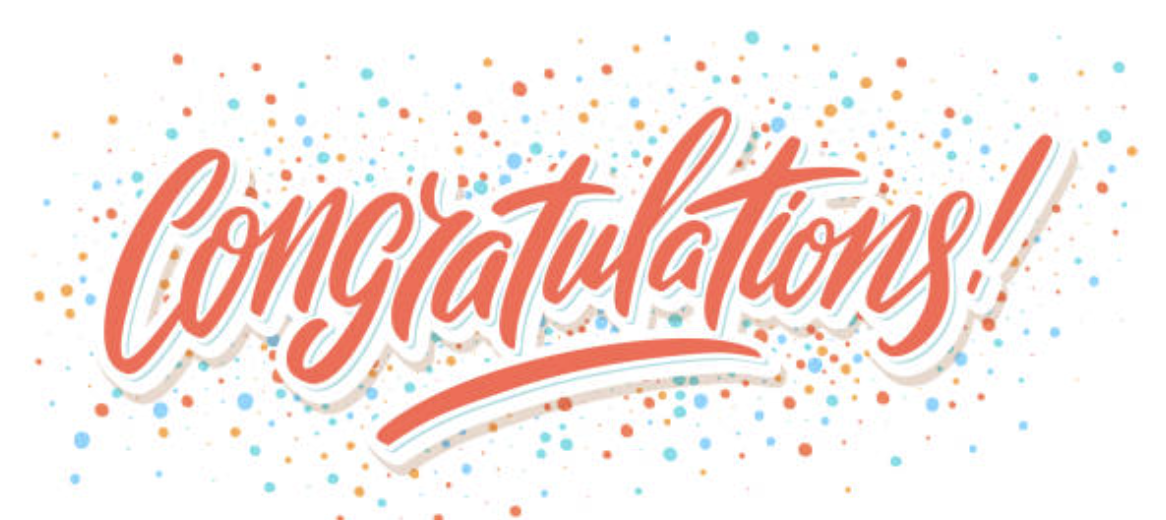

[Click Me](https://www.youtube.com/watch?v=SC4xMk98Pdc)

As always please ask questions or make improvements to the documentation

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()